In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from IPython.display import display

Data Sourced from Kaggle competition. 
Link: https://www.kaggle.com/saurabh00007/diabetescsv

In [2]:
train =pd.read_csv("diabetes.csv")
train.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Analyze Data columns

In [3]:
train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Preform statistical analysis on features 

In [4]:
corr = train.corr()
corr['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

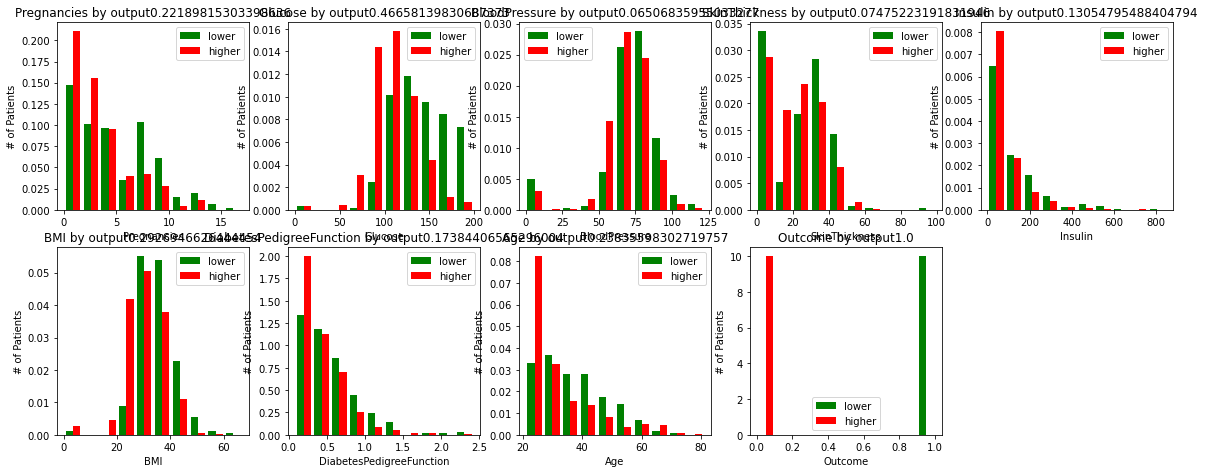

In [5]:
fig = plt.figure(figsize = (20,20))
i=1
for row in train.columns:
    fig.add_subplot(5,5,i)
    plt.hist(x = [train[train['Outcome']==1][row], train[train['Outcome']==0][row]], density=True,histtype='bar', color = ['g','r'],label = ['lower','higher'])
    plt.title(row+' by output'+str(corr['Outcome'][row]))
    plt.xlabel(row)
    plt.ylabel('# of Patients')
    plt.legend() 
    i+=1


Define features and target variable, normalize data for easier evaluation

In [6]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
x = train.loc[:,features ].values
y = train['Outcome']
x = MinMaxScaler().fit_transform(x)
train = pd.DataFrame(x,columns= features)
train.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000


Define Global Variables for holding all fold iterations of each algorithm

In [7]:
columns = ['TP','FP','TN','FN','TPR','TNR','FPR','FNR','Recall','Precision','F1','Accuracy','Error','BACC','TSS','HSS']
LSTMavg = pd.DataFrame(columns =columns)
RFavg = pd.DataFrame(columns =columns)
KNNavg = pd.DataFrame(columns =columns)

Define function calculate to calculate statistical metrics using TP,TN,FP, and FN

In [8]:
def calculate(FN,TN,FP,TP):
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    FPR = FP/(TN + FP)
    FNR = FN/(TP + FN) 
    r = TP/(TP + FN) 
    p = TP/(TP + FP)
    F1 = (2 *TP)/(2 *TP + FP + FN)
    Acc = (TP + TN)/(TP + FP + FN + TN)
    Err = (FP + FN)/(TP + FP + FN + TN)
    bacc = (TPR+TNR)/2
    TSS= TP/(TP+FN)
    HSS = 2*((TP*TN)-(FP*FN))/((TP+FN)*(FN+TN)+(TP+FP)*(FP+TN))
    return [TP,FP,TN,FN,TPR,TNR,FPR,FNR,r,p,F1,Acc,Err,bacc,TSS,HSS]

Define function to train, predict and analyze the Confusion Matrix

Random Forest Algorithm

In [9]:
def fRF(model,k,X_train, X_test, y_train, y_test):#Random Forest
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    [[TN,  FP],
    [ FN, TP]] = confusion_matrix(y_test, y_pred) 
    fold = pd.DataFrame(calculate(FN,TN,FP,TP),index = columns,columns=[k]).T
    return fold

Long Short-Term Memory Algorithm

In [10]:
def fLSTM(model,k,X_train, X_test, y_train, y_test):#Long Short-Term Memory
    model.fit(X_train, y_train, epochs = 10, batch_size = 32,verbose=0)
    y_pred = model.predict(X_test).reshape(-1)
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1
    [[TN,  FP],
    [ FN, TP]] = confusion_matrix(y_test, y_pred) 
    fold = pd.DataFrame(calculate(FN,TN,FP,TP),index = columns,columns=[k]).T
    return fold

K-Nearest Neighbor Algorithm

In [11]:
def fKNN(model,k,X_train, X_test, y_train, y_test):#k-Nearest Neighbor
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    [[TN,  FP],
    [ FN, TP]] = confusion_matrix(y_test, y_pred) 
    fold = pd.DataFrame(calculate(FN,TN,FP,TP),index = columns,columns=[k]).T
    return fold

Create Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)

Create LSTM Neurel Network

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (8, 1)))
model.add(Dropout(0.25))
model.add(LSTM(50))
model.add(Dropout(0.25))
model.add(Dense(units = 1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = 'accuracy')

Create k-Nearest Neighbor Classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

Initialize k-Fold cross validation

In [15]:
from sklearn.model_selection import KFold
X = train
kf = KFold(n_splits=10)
splits =  kf.get_n_splits(X)

Iterate through the Kfold,train and test each algorithm at each iteration.

In [16]:
k=1

KFold(n_splits=10, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X,y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    RFfold = fRF(clf,k,X_train, X_test, y_train, y_test)
    RFavg = pd.concat([RFavg, RFfold], ignore_index = False, axis = 0)
    LSTMfold = fLSTM(model,k,X_train, X_test, y_train, y_test) 
    LSTMavg = pd.concat([LSTMavg, LSTMfold], ignore_index = False, axis = 0)
    KNNfold = fKNN(knn,k,X_train, X_test, y_train, y_test)
    KNNavg = pd.concat([KNNavg, KNNfold], ignore_index = False, axis = 0)
    fold = pd.DataFrame([RFfold.loc[k],LSTMfold.loc[k],KNNfold.loc[k]],index = pd.Index(['Random Forest','Long Short-Term Memory','k-Nearest Neighbors'],name = "KFold k = "+str(k)))
    with pd.option_context('display.colheader_justify', 'center',
                        'display.max_rows', None,
                        'display.max_columns', None,
                        'display.precision', 3,
                        ):
        display(fold)
    k+=1

,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 1,,,,,,,,,,,,,,,,
Random Forest,13.0,4.0,41.0,19.0,0.406,0.911,0.089,0.594,0.406,0.765,0.531,0.701,0.299,0.659,0.406,0.340
Long Short-Term Memory,15.0,5.0,40.0,17.0,0.469,0.889,0.111,0.531,0.469,0.750,0.577,0.714,0.286,0.679,0.469,0.378
k-Nearest Neighbors,20.0,14.0,31.0,12.0,0.625,0.689,0.311,0.375,0.625,0.588,0.606,0.662,0.338,0.657,0.625,0.311


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 2,,,,,,,,,,,,,,,,
Random Forest,7.0,1.0,54.0,15.0,0.318,0.982,0.018,0.682,0.318,0.875,0.467,0.792,0.208,0.650,0.318,0.371
Long Short-Term Memory,9.0,4.0,51.0,13.0,0.409,0.927,0.073,0.591,0.409,0.692,0.514,0.779,0.221,0.668,0.409,0.383
k-Nearest Neighbors,12.0,1.0,54.0,10.0,0.545,0.982,0.018,0.455,0.545,0.923,0.686,0.857,0.143,0.764,0.545,0.601


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 3,,,,,,,,,,,,,,,,
Random Forest,13.0,3.0,40.0,21.0,0.382,0.930,0.070,0.618,0.382,0.812,0.520,0.688,0.312,0.656,0.382,0.331
Long Short-Term Memory,16.0,6.0,37.0,18.0,0.471,0.860,0.140,0.529,0.471,0.727,0.571,0.688,0.312,0.666,0.471,0.344
k-Nearest Neighbors,17.0,8.0,35.0,17.0,0.500,0.814,0.186,0.500,0.500,0.680,0.576,0.675,0.325,0.657,0.500,0.323


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 4,,,,,,,,,,,,,,,,
Random Forest,9.0,6.0,41.0,21.0,0.300,0.872,0.128,0.700,0.300,0.600,0.400,0.649,0.351,0.586,0.300,0.189
Long Short-Term Memory,11.0,10.0,37.0,19.0,0.367,0.787,0.213,0.633,0.367,0.524,0.431,0.623,0.377,0.577,0.367,0.163
k-Nearest Neighbors,17.0,10.0,37.0,13.0,0.567,0.787,0.213,0.433,0.567,0.630,0.596,0.701,0.299,0.677,0.567,0.360


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 5,,,,,,,,,,,,,,,,
Random Forest,9.0,2.0,48.0,18.0,0.333,0.96,0.04,0.667,0.333,0.818,0.474,0.740,0.260,0.647,0.333,0.340
Long Short-Term Memory,9.0,3.0,47.0,18.0,0.333,0.94,0.06,0.667,0.333,0.750,0.462,0.727,0.273,0.637,0.333,0.313
k-Nearest Neighbors,15.0,5.0,45.0,12.0,0.556,0.90,0.10,0.444,0.556,0.750,0.638,0.779,0.221,0.728,0.556,0.484


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 6,,,,,,,,,,,,,,,,
Random Forest,12.0,1.0,46.0,18.0,0.400,0.979,0.021,0.600,0.400,0.923,0.558,0.753,0.247,0.689,0.400,0.422
Long Short-Term Memory,16.0,6.0,41.0,14.0,0.533,0.872,0.128,0.467,0.533,0.727,0.615,0.740,0.260,0.703,0.533,0.426
k-Nearest Neighbors,15.0,7.0,40.0,15.0,0.500,0.851,0.149,0.500,0.500,0.682,0.577,0.714,0.286,0.676,0.500,0.369


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 7,,,,,,,,,,,,,,,,
Random Forest,5.0,5.0,58.0,9.0,0.357,0.921,0.079,0.643,0.357,0.500,0.417,0.818,0.182,0.639,0.357,0.312
Long Short-Term Memory,6.0,9.0,54.0,8.0,0.429,0.857,0.143,0.571,0.429,0.400,0.414,0.779,0.221,0.643,0.429,0.278
k-Nearest Neighbors,9.0,13.0,50.0,5.0,0.643,0.794,0.206,0.357,0.643,0.409,0.500,0.766,0.234,0.718,0.643,0.357


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 8,,,,,,,,,,,,,,,,
Random Forest,10.0,3.0,49.0,15.0,0.40,0.942,0.058,0.60,0.40,0.769,0.526,0.766,0.234,0.671,0.40,0.391
Long Short-Term Memory,15.0,5.0,47.0,10.0,0.60,0.904,0.096,0.40,0.60,0.750,0.667,0.805,0.195,0.752,0.60,0.531
k-Nearest Neighbors,18.0,6.0,46.0,7.0,0.72,0.885,0.115,0.28,0.72,0.750,0.735,0.831,0.169,0.802,0.72,0.611


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 9,,,,,,,,,,,,,,,,
Random Forest,6.0,4.0,48.0,18.0,0.250,0.923,0.077,0.750,0.250,0.600,0.353,0.711,0.289,0.587,0.250,0.205
Long Short-Term Memory,12.0,9.0,43.0,12.0,0.500,0.827,0.173,0.500,0.500,0.571,0.533,0.724,0.276,0.663,0.500,0.338
k-Nearest Neighbors,13.0,10.0,42.0,11.0,0.542,0.808,0.192,0.458,0.542,0.565,0.553,0.724,0.276,0.675,0.542,0.353


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
KFold k = 10,,,,,,,,,,,,,,,,
Random Forest,13.0,1.0,45.0,17.0,0.433,0.978,0.022,0.567,0.433,0.929,0.591,0.763,0.237,0.706,0.433,0.454
Long Short-Term Memory,18.0,5.0,41.0,12.0,0.600,0.891,0.109,0.400,0.600,0.783,0.679,0.776,0.224,0.746,0.600,0.512
k-Nearest Neighbors,17.0,7.0,39.0,13.0,0.567,0.848,0.152,0.433,0.567,0.708,0.630,0.737,0.263,0.707,0.567,0.429


Display data analysis at each k fold iteration and display average values for each algorithm

In [19]:
avg = pd.DataFrame([RFavg.sum()/10,LSTMavg.sum()/10,KNNavg.sum()/10],index = pd.Index(['Random Forest','Long Short-Term Memory','k-Nearest Neighbors'],name = 'Overall Average Values:'))
RFavg.index.name = 'Random Forest'
LSTMavg.index.name = 'Long Short-Term Memory'
KNNavg.index.name = 'k-Nearest Neighbors'
avg.style.set_properties(**{'text-align': 'center'})
with pd.option_context('display.colheader_justify', 'center',
                    'display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(RFavg)
    display(LSTMavg)
    display(KNNavg)
    display(avg)

,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
Random Forest,,,,,,,,,,,,,,,,
1,13.0,4.0,41.0,19.0,0.406,0.911,0.089,0.594,0.406,0.765,0.531,0.701,0.299,0.659,0.406,0.340
2,7.0,1.0,54.0,15.0,0.318,0.982,0.018,0.682,0.318,0.875,0.467,0.792,0.208,0.650,0.318,0.371
3,13.0,3.0,40.0,21.0,0.382,0.930,0.070,0.618,0.382,0.812,0.520,0.688,0.312,0.656,0.382,0.331
4,9.0,6.0,41.0,21.0,0.300,0.872,0.128,0.700,0.300,0.600,0.400,0.649,0.351,0.586,0.300,0.189
5,9.0,2.0,48.0,18.0,0.333,0.960,0.040,0.667,0.333,0.818,0.474,0.740,0.260,0.647,0.333,0.340
6,12.0,1.0,46.0,18.0,0.400,0.979,0.021,0.600,0.400,0.923,0.558,0.753,0.247,0.689,0.400,0.422
7,5.0,5.0,58.0,9.0,0.357,0.921,0.079,0.643,0.357,0.500,0.417,0.818,0.182,0.639,0.357,0.312
8,10.0,3.0,49.0,15.0,0.400,0.942,0.058,0.600,0.400,0.769,0.526,0.766,0.234,0.671,0.400,0.391
9,6.0,4.0,48.0,18.0,0.250,0.923,0.077,0.750,0.250,0.600,0.353,0.711,0.289,0.587,0.250,0.205


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
Long Short-Term Memory,,,,,,,,,,,,,,,,
1,15.0,5.0,40.0,17.0,0.469,0.889,0.111,0.531,0.469,0.750,0.577,0.714,0.286,0.679,0.469,0.378
2,9.0,4.0,51.0,13.0,0.409,0.927,0.073,0.591,0.409,0.692,0.514,0.779,0.221,0.668,0.409,0.383
3,16.0,6.0,37.0,18.0,0.471,0.860,0.140,0.529,0.471,0.727,0.571,0.688,0.312,0.666,0.471,0.344
4,11.0,10.0,37.0,19.0,0.367,0.787,0.213,0.633,0.367,0.524,0.431,0.623,0.377,0.577,0.367,0.163
5,9.0,3.0,47.0,18.0,0.333,0.940,0.060,0.667,0.333,0.750,0.462,0.727,0.273,0.637,0.333,0.313
6,16.0,6.0,41.0,14.0,0.533,0.872,0.128,0.467,0.533,0.727,0.615,0.740,0.260,0.703,0.533,0.426
7,6.0,9.0,54.0,8.0,0.429,0.857,0.143,0.571,0.429,0.400,0.414,0.779,0.221,0.643,0.429,0.278
8,15.0,5.0,47.0,10.0,0.600,0.904,0.096,0.400,0.600,0.750,0.667,0.805,0.195,0.752,0.600,0.531
9,12.0,9.0,43.0,12.0,0.500,0.827,0.173,0.500,0.500,0.571,0.533,0.724,0.276,0.663,0.500,0.338


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
k-Nearest Neighbors,,,,,,,,,,,,,,,,
1,20.0,14.0,31.0,12.0,0.625,0.689,0.311,0.375,0.625,0.588,0.606,0.662,0.338,0.657,0.625,0.311
2,12.0,1.0,54.0,10.0,0.545,0.982,0.018,0.455,0.545,0.923,0.686,0.857,0.143,0.764,0.545,0.601
3,17.0,8.0,35.0,17.0,0.500,0.814,0.186,0.500,0.500,0.680,0.576,0.675,0.325,0.657,0.500,0.323
4,17.0,10.0,37.0,13.0,0.567,0.787,0.213,0.433,0.567,0.630,0.596,0.701,0.299,0.677,0.567,0.360
5,15.0,5.0,45.0,12.0,0.556,0.900,0.100,0.444,0.556,0.750,0.638,0.779,0.221,0.728,0.556,0.484
6,15.0,7.0,40.0,15.0,0.500,0.851,0.149,0.500,0.500,0.682,0.577,0.714,0.286,0.676,0.500,0.369
7,9.0,13.0,50.0,5.0,0.643,0.794,0.206,0.357,0.643,0.409,0.500,0.766,0.234,0.718,0.643,0.357
8,18.0,6.0,46.0,7.0,0.720,0.885,0.115,0.280,0.720,0.750,0.735,0.831,0.169,0.802,0.720,0.611
9,13.0,10.0,42.0,11.0,0.542,0.808,0.192,0.458,0.542,0.565,0.553,0.724,0.276,0.675,0.542,0.353


,TP,FP,TN,FN,TPR,TNR,FPR,FNR,Recall,Precision,F1,Accuracy,Error,BACC,TSS,HSS
Overall Average Values:,,,,,,,,,,,,,,,,
Random Forest,9.7,3.0,47.0,17.1,0.358,0.940,0.060,0.642,0.358,0.759,0.484,0.738,0.262,0.649,0.358,0.336
Long Short-Term Memory,12.7,6.2,43.8,14.1,0.471,0.876,0.124,0.529,0.471,0.667,0.546,0.736,0.264,0.673,0.471,0.367
k-Nearest Neighbors,15.3,8.1,41.9,11.5,0.576,0.836,0.164,0.424,0.576,0.669,0.610,0.745,0.255,0.706,0.576,0.420
